# Using Scikit-Learn Pipelines

In this notebook we will look at how you can use some of the advanced parts of the scikit-learn package, specific pipelines and parameter optimisation.


The scikit-learn Pipeline utility has been provided to help automate machine learning workflows. Pipelines work by allowing for a linear sequence of data transforms to be chained together culminating in a modeling process that can be evaluated. Tranforms can include data scalers (i.e., data normalisation), feature selection and end with a classifier (or regression).


## Running Notebook

The notebook has been run and saved with the outputs so you can see what the outputs should be and so the notebook and be browsed online without having to run the notebook for it to make sense. 

If you are running the notebook for yourself it is recommended that you clear the existing outputs which can be done by running one of the following options depending on what system you are using:

**Jupyter-lab**:

> \> _Edit_ \> _'Clear All Outputs'_

**Jupyter-notebook**:

> \> _Cell_ \> _'All Outputs'_ \> _Clear_

# 1. Import Modules

In [1]:
import os

import geopandas

# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import rsgislib.classification
import rsgislib.classification.classsklearn
import rsgislib.tools.plotting
import rsgislib.tools.utils
import rsgislib.vectorutils
from rsgislib.classification import ClassInfoObj

# Import the function to calculate the accuracy stats
from rsgislib.classification.classaccuracymetrics import calc_acc_metrics_vecsamples_img
from rsgislib.imageutils import ImageBandInfo

# 2. Import Scikit-Learn Classifiers

In [2]:
from sklearn.ensemble import ExtraTreesClassifier

# Feature selector
from sklearn.feature_selection import VarianceThreshold

# For optimization
from sklearn.model_selection import GridSearchCV

# For setting up pipeline
from sklearn.pipeline import Pipeline

# Various pre-processing steps
from sklearn.preprocessing import (
    LabelEncoder,
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    StandardScaler,
)

# 3. Create Output Directory

In [3]:
out_cls_dir = "cls_adv_skl_refl_results"
if not os.path.exists(out_cls_dir):
    os.mkdir(out_cls_dir)

# 4. Define the Input Image

In [4]:
input_img = "../data/sen2_20180629_t30uvd_orb037_osgb_stdsref_20m.tif"
imgs_info = []
imgs_info.append(
    ImageBandInfo(
        file_name=input_img, name="sen2", bands=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    )
)

valid_img = "../data/sen2_20180629_t30uvd_orb037_osgb_stdsref_20m_vmsk.tif"

# 5. Define Sample Data and Class Colours

In [5]:
cls_smpl_info = dict()
cls_smpl_info["Artificial_Surfaces"] = ClassInfoObj(
    id=0,
    out_id=1,
    train_file_h5="training_data/artificial_surfaces_refl_smpls_train.h5",
    test_file_h5="training_data/artificial_surfaces_refl_smpls_test.h5",
    valid_file_h5="training_data/artificial_surfaces_refl_smpls_valid.h5",
    red=160,
    green=160,
    blue=160,
)
cls_smpl_info["Bare_Rock_Sand"] = ClassInfoObj(
    id=1,
    out_id=2,
    train_file_h5="training_data/bare_rock_sand_refl_smpls_train.h5",
    test_file_h5="training_data/bare_rock_sand_refl_smpls_test.h5",
    valid_file_h5="training_data/bare_rock_sand_refl_smpls_valid.h5",
    red=100,
    green=100,
    blue=100,
)
cls_smpl_info["Bracken"] = ClassInfoObj(
    id=2,
    out_id=3,
    train_file_h5="training_data/bracken_refl_smpls_train.h5",
    test_file_h5="training_data/bracken_refl_smpls_test.h5",
    valid_file_h5="training_data/bracken_refl_smpls_valid.h5",
    red=235,
    green=146,
    blue=38,
)
cls_smpl_info["Conifer_Forest"] = ClassInfoObj(
    id=3,
    out_id=4,
    train_file_h5="training_data/conifer_forest_refl_smpls_train.h5",
    test_file_h5="training_data/conifer_forest_refl_smpls_test.h5",
    valid_file_h5="training_data/conifer_forest_refl_smpls_valid.h5",
    red=2,
    green=97,
    blue=16,
)
cls_smpl_info["Deciduous_Forest"] = ClassInfoObj(
    id=4,
    out_id=5,
    train_file_h5="training_data/deciduous_forest_refl_smpls_train.h5",
    test_file_h5="training_data/deciduous_forest_refl_smpls_test.h5",
    valid_file_h5="training_data/deciduous_forest_refl_smpls_valid.h5",
    red=50,
    green=184,
    blue=69,
)
cls_smpl_info["Grass_Long"] = ClassInfoObj(
    id=5,
    out_id=6,
    train_file_h5="training_data/grass_long_refl_smpls_train.h5",
    test_file_h5="training_data/grass_long_refl_smpls_test.h5",
    valid_file_h5="training_data/grass_long_refl_smpls_valid.h5",
    red=150,
    green=227,
    blue=18,
)
cls_smpl_info["Grass_Short"] = ClassInfoObj(
    id=6,
    out_id=7,
    train_file_h5="training_data/grass_short_refl_smpls_train.h5",
    test_file_h5="training_data/grass_short_refl_smpls_test.h5",
    valid_file_h5="training_data/grass_short_refl_smpls_valid.h5",
    red=194,
    green=219,
    blue=66,
)
cls_smpl_info["NonPhoto_Veg"] = ClassInfoObj(
    id=7,
    out_id=8,
    train_file_h5="training_data/nonphoto_veg_refl_smpls_train.h5",
    test_file_h5="training_data/nonphoto_veg_refl_smpls_test.h5",
    valid_file_h5="training_data/nonphoto_veg_refl_smpls_valid.h5",
    red=98,
    green=225,
    blue=227,
)
cls_smpl_info["Scrub"] = ClassInfoObj(
    id=8,
    out_id=9,
    train_file_h5="training_data/scrub_refl_smpls_train.h5",
    test_file_h5="training_data/scrub_refl_smpls_test.h5",
    valid_file_h5="training_data/scrub_refl_smpls_valid.h5",
    red=0,
    green=80,
    blue=0,
)
cls_smpl_info["Water"] = ClassInfoObj(
    id=9,
    out_id=10,
    train_file_h5="training_data/water_refl_smpls_train.h5",
    test_file_h5="training_data/water_refl_smpls_test.h5",
    valid_file_h5="training_data/water_refl_smpls_valid.h5",
    red=0,
    green=0,
    blue=255,
)

# 6. Set up scikit-learn Pipeline

In [6]:
# The parameters are the values which are to be used within the grid search to 
# identify the optimal parameters, scaling and features for undertaking the 
# classification.
parameters = {
    "scaler": [StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler()],
    "selector__threshold": [0, 0.001, 0.01],
    "classifier__n_estimators": [25, 50, 75, 100, 200],
    "classifier__max_depth": [1, 2, 3, 4, 5],
    "classifier__min_samples_split": [0.1, 0.25, 0.5, 0.75, 0.99],
}

# Set up the pipeline with some default parameters. 
# The pipeline will first scale the input data and 
# then apply a feature selection before applying
# the classifier.
sk_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("selector", VarianceThreshold()),
        ("classifier", ExtraTreesClassifier()),
    ]
)

# Set up the grid search to use the pipeline and parameters
# defined above. In this case we will also use a cross validation
# of 2 (cv=2)
grid_search = GridSearchCV(sk_pipe, parameters, cv=2, verbose=1)

# 7. Optimise Pipeline Parameters

Note. this can take a little while to process through - it will be testing 3000 combinations of parameters!

In [7]:
sk_cls = rsgislib.classification.classsklearn.perform_sklearn_classifier_param_search(
    cls_smpl_info, grid_search
)

Training data size: 534 x 10
Fitting 2 folds for each of 1500 candidates, totalling 3000 fits
Best score was 0.9307116104868913 and has parameters {'classifier__max_depth': 5, 'classifier__min_samples_split': 0.1, 'classifier__n_estimators': 75, 'scaler': StandardScaler(), 'selector__threshold': 0.001}.


# 8. Train the Classifier

In [8]:
# Train the classifier
(train_acc, test_acc,) = rsgislib.classification.classsklearn.train_sklearn_classifier(
    cls_smpl_info, sk_cls
)

print(f"Train Accuracy: {train_acc}")
print(f"Train Accuracy: {test_acc}")

Training data size: 3540 x 10
Testing data size: 534 x 10
Training Classifier
Completed
Calc Classifier Accuracy
Classifier Train Score = 91.72%
Classifier Test Score = 91.2%
Train Accuracy: 0.9172316384180791
Train Accuracy: 0.9119850187265918


# 8. Apply Classifier

In [9]:
out_cls_img = os.path.join(out_cls_dir, "cls_skl_pipe_refl.kea")
rsgislib.classification.classsklearn.apply_sklearn_classifier(
    cls_smpl_info,
    sk_cls,
    valid_img,
    1,
    imgs_info,
    out_cls_img,
    "KEA",
    class_clr_names=True,
)

Applying the Classifier


  0%|          | 0/100 [00:00<?, ?it/s]

Completed
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Apply Colour to class 'Artificial_Surfaces'
Apply Colour to class 'Bare_Rock_Sand'
Apply Colour to class 'Bracken'
Apply Colour to class 'Conifer_Forest'
Apply Colour to class 'Deciduous_Forest'
Apply Colour to class 'Grass_Long'
Apply Colour to class 'Grass_Short'
Apply Colour to class 'NonPhoto_Veg'
Apply Colour to class 'Scrub'
Apply Colour to class 'Water'


# 9. Visualise the Classification Result

Image Data Size: 3295 x 2880


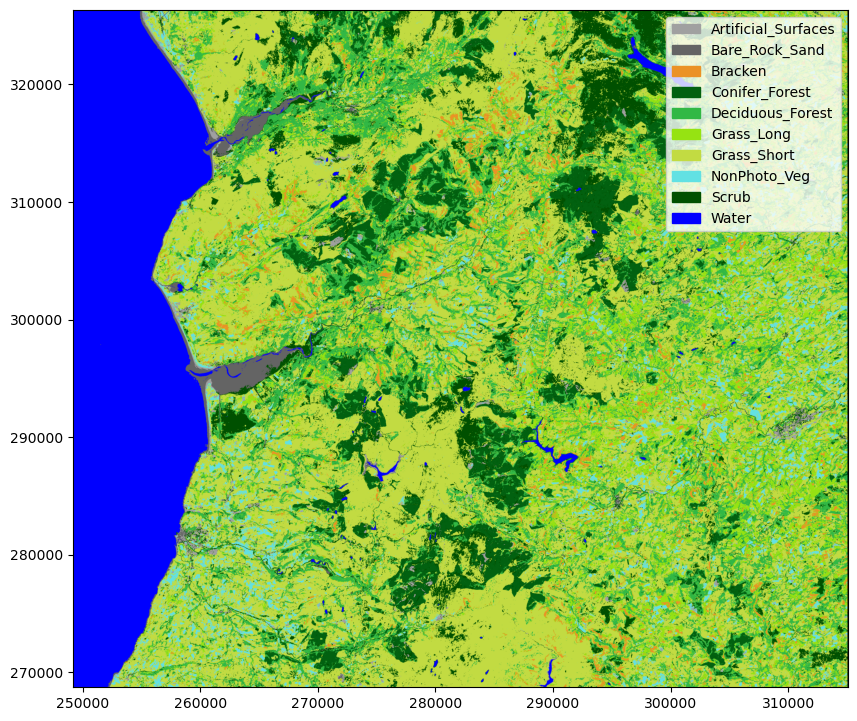

In [10]:
# Define a look up table (LUT) for the class names
# to be used to generate the legend for the map.
cls_names_lut = dict()
for cls_name in cls_smpl_info:
    cls_names_lut[cls_smpl_info[cls_name].out_id] = cls_name


# Get the image data using the get_gdal_thematic_raster_mpl_imshow function.
(
    img_data,
    img_coords,
    lgd_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(
    out_cls_img, out_patches=True, cls_names_lut=cls_names_lut
)

# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax.imshow(img_data, extent=img_coords)

# Add the legend to the plot using the patches from the
# get_gdal_thematic_raster_mpl_imshow function.
ax.legend(handles=lgd_patches)

# 10. Create Accuracy Output Directories

In [11]:
out_pts_dir = "acc_pts"
if not os.path.exists(out_pts_dir):
    os.mkdir(out_pts_dir)

out_stats_dir = "acc_stats"
if not os.path.exists(out_stats_dir):
    os.mkdir(out_stats_dir)

# 11. Define Input Reference Points

In [12]:
vec_file = "../data/cls_data/cls_acc_assessment_pts_ref.geojson"
vec_lyr = "cls_acc_assessment_pts_ref"

# 12. Copy Existing Points File

To avoid overwriting and editting the input file provided we will first copy it into our output directory.

In [13]:
vec_refpts_file = os.path.join(
    out_pts_dir, "cls_acc_assessment_pts_skl_adv_ref.geojson"
)
vec_refpts_lyr = "cls_acc_assessment_pts_skl_adv_ref"

rsgislib.vectorutils.vector_translate(
    vec_file,
    vec_lyr,
    vec_refpts_file,
    vec_refpts_lyr,
    out_format="GeoJSON",
    del_exist_vec=True,
)

Deleting: acc_pts/cls_acc_assessment_pts_skl_adv_ref.geojson


101it [00:00, 11638.36it/s]                                                                                                                                        


# 13. Populate Reference Points

In [14]:
rsgislib.classification.pop_class_info_accuracy_pts(
    input_img=out_cls_img,
    vec_file=vec_refpts_file,
    vec_lyr=vec_refpts_lyr,
    rat_class_col="class_names",
    vec_class_col="skl_adv_cls",
    vec_ref_col=None,
    vec_process_col=None,
)

# 14. Filter Valid Points

Some classifiers can produce no data regions and if those intersect with reference points then an error will occur when calculating the accuracy statistics so we need to remove those which we will do using geopandas. For points where there is no class (i.e., no data) in the input classification then the value `"NA"` is outputted into the attribute table and it is rows with an `"NA"` value that we want to remove.


In [15]:
vec_refpts_vld_file = os.path.join(
    out_pts_dir, "cls_acc_assessment_pts_skl_adv_ref_vld.geojson"
)
vec_refpts_vld_lyr = "cls_acc_assessment_pts_skl_adv_ref_vld"
points_gdf = geopandas.read_file(vec_refpts_file)
points_gdf = points_gdf.drop(points_gdf[points_gdf["skl_adv_cls"] == "NA"].index)
points_gdf.to_file(vec_refpts_vld_file, driver="GeoJSON")
points_gdf

,ref_pts,skl_adv_cls,geometry
0,Bare_Rock_Sand,Artificial_Surfaces,POINT (293492.332 306597.255)
1,Artificial_Surfaces,Grass_Short,POINT (312462.332 304967.255)
2,Bare_Rock_Sand,Scrub,POINT (306412.332 293567.255)
3,Artificial_Surfaces,Grass_Short,POINT (259012.332 309877.255)
4,Artificial_Surfaces,Artificial_Surfaces,POINT (305842.332 323467.255)
...,...,...,...
995,Water,Water,POINT (250902.332 316807.255)
996,Water,Water,POINT (257912.332 297147.255)
997,Water,Water,POINT (249762.332 311677.255)
998,Water,Water,POINT (253712.332 295707.255)


# 15. Calculate the Accuracy Statistics

In [16]:
out_json_file = os.path.join(out_stats_dir, "cls_skl_adv_acc_info.json")
out_csv_file = os.path.join(out_stats_dir, "cls_skl_adv_acc_info.csv")

calc_acc_metrics_vecsamples_img(
    vec_file=vec_refpts_vld_file,
    vec_lyr=vec_refpts_vld_lyr,
    ref_col="ref_pts",
    cls_col="skl_adv_cls",
    cls_img=out_cls_img,
    img_cls_name_col="class_names",
    img_hist_col="Histogram",
    out_json_file=out_json_file,
    out_csv_file=out_csv_file,
)

{'Artificial_Surfaces': {'precision': 0.4,
  'recall': 0.3939393939393939,
  'f1-score': 0.39694656488549623,
  'support': 66},
 'Bare_Rock_Sand': {'precision': 0.6428571428571429,
  'recall': 0.6081081081081081,
  'f1-score': 0.625,
  'support': 74},
 'Bracken': {'precision': 0.84,
  'recall': 0.40384615384615385,
  'f1-score': 0.5454545454545454,
  'support': 52},
 'Conifer_Forest': {'precision': 0.9245283018867925,
  'recall': 0.9423076923076923,
  'f1-score': 0.9333333333333333,
  'support': 104},
 'Deciduous_Forest': {'precision': 0.5918367346938775,
  'recall': 0.8787878787878788,
  'f1-score': 0.7073170731707316,
  'support': 99},
 'Grass_Long': {'precision': 0.6938775510204082,
  'recall': 0.48226950354609927,
  'f1-score': 0.5690376569037657,
  'support': 141},
 'Grass_Short': {'precision': 0.5348837209302325,
  'recall': 0.9349593495934959,
  'f1-score': 0.680473372781065,
  'support': 123},
 'NonPhoto_Veg': {'precision': 0.8671875,
  'recall': 0.7708333333333334,
  'f1-score

# 16. Reading the JSON file

Let's now have a look at the JSON file which has been outputted. One thing you will notice is this isn't the most user friendly way of presenting this data, hence why the function also outputs a CSV. However, it easy to read out particular values in python, as shown below.

In [17]:
import pprint

cls_acc_stats_dict = rsgislib.tools.utils.read_json_to_dict(out_json_file)
pprint.pprint(cls_acc_stats_dict)

{'Artificial_Surfaces': {'f1-score': 0.39694656488549623,
                         'precision': 0.4,
                         'recall': 0.3939393939393939,
                         'support': 66},
 'Bare_Rock_Sand': {'f1-score': 0.625,
                    'precision': 0.6428571428571429,
                    'recall': 0.6081081081081081,
                    'support': 74},
 'Bracken': {'f1-score': 0.5454545454545454,
             'precision': 0.84,
             'recall': 0.40384615384615385,
             'support': 52},
 'Conifer_Forest': {'f1-score': 0.9333333333333333,
                    'precision': 0.9245283018867925,
                    'recall': 0.9423076923076923,
                    'support': 104},
 'Deciduous_Forest': {'f1-score': 0.7073170731707316,
                      'precision': 0.5918367346938775,
                      'recall': 0.8787878787878788,
                      'support': 99},
 'Grass_Long': {'f1-score': 0.5690376569037657,
                'precision': 0.69387

In [18]:
print("Overall Accuracy: {}".format(cls_acc_stats_dict["accuracy"]))
print("Macro F1 Score: {}".format(cls_acc_stats_dict["macro avg"]["f1-score"]))
print(
    "Area Weighted F1 Score: {}".format(
        cls_acc_stats_dict["weighted area avg"]["f1-score"]
    )
)

Overall Accuracy: 0.7047047047047047
Macro F1 Score: 0.6720669724956361
Area Weighted F1 Score: 0.709971234360302
